In [1]:
# SEL 1 (VERSI BARU)

import os
import json
import mmcv
from mmengine.config import Config, DictAction
from mmengine.runner import Runner  # <--- GANTI BAGIAN INI
from mmdet.utils import register_all_modules
import numpy as np

# ============== KONFIGURASI UTAMA =================
# Cukup ubah variabel di bagian ini untuk menyesuaikan proyek

# Nama proyek (digunakan untuk membuat folder output)
PROJECT_NAME = "BreadDetector_SSD_MobileNetV3"

# Path ke direktori utama dataset COCO Anda
DATASET_ROOT = 'dataset'

# Daftar 10 kelas yang ingin digunakan
CLASSES_TO_USE = [
    'baguette', 'cornbread', 'croissant', 'ensaymada', 'flatbread',
    'sourdough', 'wheat-bread', 'white-bread', 'whole-grain-bread', 'pandesal'
]
NUM_CLASSES = len(CLASSES_TO_USE)

# Hyperparameters
BASE_LR = 0.001
BATCH_SIZE = 32 # Sesuaikan dengan VRAM GPU Anda, 32 mungkin terlalu besar untuk GPU umum
EPOCHS = 1
IMG_SIZE = (416, 416)

# Path untuk output (log, checkpoint, model terbaik)
WORK_DIR = f"outputs/{PROJECT_NAME}"

# Pastikan direktori output ada
os.makedirs(WORK_DIR, exist_ok=True)

print(f"Project Name: {PROJECT_NAME}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Classes: {CLASSES_TO_USE}")
print(f"Output Directory: {WORK_DIR}")

Project Name: BreadDetector_SSD_MobileNetV3
Number of Classes: 10
Classes: ['baguette', 'cornbread', 'croissant', 'ensaymada', 'flatbread', 'sourdough', 'wheat-bread', 'white-bread', 'whole-grain-bread', 'pandesal']
Output Directory: outputs/BreadDetector_SSD_MobileNetV3


In [2]:
def filter_coco_annotations(original_ann_file, new_ann_file, classes_to_keep):
    """
    Membaca file anotasi COCO, memfilter hanya untuk kelas yang diinginkan,
    dan menyimpan sebagai file anotasi baru.
    """
    print(f"Memproses file anotasi: {original_ann_file}")

    with open(original_ann_file, 'r') as f:
        coco_data = json.load(f)

    # Buat mapping dari nama kelas ke ID di file asli
    original_categories = {cat['name']: cat['id'] for cat in coco_data['categories']}
    
    # Filter kategori
    new_categories = []
    # Buat mapping dari ID lama ke ID baru (0 hingga N-1)
    old_id_to_new_id = {}
    new_cat_id = 0
    for cat_name in classes_to_keep:
        if cat_name in original_categories:
            new_categories.append({'id': new_cat_id, 'name': cat_name, 'supercategory': 'object'})
            old_id_to_new_id[original_categories[cat_name]] = new_cat_id
            new_cat_id += 1
    
    if not new_categories:
        print("Peringatan: Tidak ada kelas yang cocok ditemukan di file anotasi.")
        return

    # Filter anotasi
    new_annotations = []
    image_ids_with_annotations = set()
    for ann in coco_data['annotations']:
        if ann['category_id'] in old_id_to_new_id:
            ann['category_id'] = old_id_to_new_id[ann['category_id']]
            new_annotations.append(ann)
            image_ids_with_annotations.add(ann['image_id'])

    # Filter gambar (hanya simpan gambar yang memiliki anotasi dari kelas yang kita inginkan)
    new_images = [img for img in coco_data['images'] if img['id'] in image_ids_with_annotations]

    # Buat data COCO baru
    new_coco_data = {
        'images': new_images,
        'annotations': new_annotations,
        'categories': new_categories,
        'info': coco_data.get('info', {}),
        'licenses': coco_data.get('licenses', [])
    }

    # Simpan file anotasi baru
    os.makedirs(os.path.dirname(new_ann_file), exist_ok=True)
    with open(new_ann_file, 'w') as f:
        json.dump(new_coco_data, f, indent=4)
        
    print(f"File anotasi baru disimpan di: {new_ann_file}")
    print(f"Total gambar setelah filter: {len(new_images)}")
    print(f"Total anotasi setelah filter: {len(new_annotations)}")
    print("-" * 30)

# Path ke file anotasi asli dan path untuk menyimpan file baru
original_train_ann = os.path.join(DATASET_ROOT, 'train', '_annotations.coco.json')
filtered_train_ann = os.path.join(DATASET_ROOT, 'train', 'filtered_annotations.coco.json')

original_valid_ann = os.path.join(DATASET_ROOT, 'valid', '_annotations.coco.json')
filtered_valid_ann = os.path.join(DATASET_ROOT, 'valid', 'filtered_annotations.coco.json')

# Jalankan fungsi filter
filter_coco_annotations(original_train_ann, filtered_train_ann, CLASSES_TO_USE)
filter_coco_annotations(original_valid_ann, filtered_valid_ann, CLASSES_TO_USE)

Memproses file anotasi: dataset\train\_annotations.coco.json
File anotasi baru disimpan di: dataset\train\filtered_annotations.coco.json
Total gambar setelah filter: 1977
Total anotasi setelah filter: 6234
------------------------------
Memproses file anotasi: dataset\valid\_annotations.coco.json
File anotasi baru disimpan di: dataset\valid\filtered_annotations.coco.json
Total gambar setelah filter: 567
Total anotasi setelah filter: 1658
------------------------------


In [3]:
from mmengine import Config
from mmdet.utils import register_all_modules
import os

# --- Langkah 1: Load base config SSD300 ---
base_config_file = 'mmdetection/configs/ssd/ssd300_coco.py'
cfg = Config.fromfile(base_config_file)
register_all_modules()

cfg.custom_imports = dict(packages=['mmpretrain'], allow_failed_imports=False)

cfg.model.backbone = dict(
    type='mmpretrain.MobileNetV3',   # pakai prefix mmpretrain
    arch='large',
    out_indices=(1, 3, 6, 12, 16),
    frozen_stages=-1,
    norm_cfg=dict(type='BN', eps=0.001, momentum=0.03),
    init_cfg = None

)

# --- Langkah 3: Sesuaikan neck dan bbox head dengan output backbone (FIXED) ---
cfg.model.neck = dict(
    type='SSDNeck',
    in_channels=[16, 24, 40, 112, 960],
    out_channels=[16, 24, 40, 112, 960, 256, 128, 64],
    level_strides=[2, 2, 2],
    level_paddings=[1, 1, 1],
    l2_norm_scale=20
)

cfg.model.bbox_head.in_channels = [16, 24, 40, 112, 960, 256, 128, 64]
cfg.model.bbox_head.num_classes = NUM_CLASSES
cfg.model.bbox_head.type = 'CustomSSDHead'
cfg.model.bbox_head.loss_cls = dict(type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0)
cfg.model.bbox_head.loss_bbox = dict(type='L1Loss', loss_weight=1.0)



# --- Langkah 4: Ubah anchor generator agar sesuai resolusi feature map backbone ---
cfg.model.bbox_head.anchor_generator = dict(
    type='SSDAnchorGenerator',
    scale_major=False,
    input_size=416,
    # Tambahkan stride untuk 3 feature map tambahan dari neck
    strides=[8, 16, 32, 64, 128, 208, 416, 416], # Contoh penambahan, mungkin butuh nilai berbeda
    ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2], [2], [2]], # Tambahkan 3 set rasio
    # Tambahkan min/max sizes untuk 3 level tambahan
    min_sizes=[21, 45, 99, 153, 207, 261, 315, 360],
    max_sizes=[45, 99, 153, 207, 261, 315, 360, 400]
)

# --- Langkah 5: Ubah konfigurasi dataset & training ---
# --- Langkah 5 (versi FIXED): Ubah konfigurasi dataset & training ---
cfg.data_root = DATASET_ROOT

# TRAIN
cfg.train_dataloader.dataset = dict(
    type='RepeatDataset',
    times=1,  # bisa kamu ubah kalau mau augmentasi berulang
    dataset=dict(
        type='CocoDataset',
        data_root=DATASET_ROOT,
        ann_file='train/filtered_annotations.coco.json',
        data_prefix=dict(img='train/'),
        metainfo=dict(classes=CLASSES_TO_USE),
        pipeline=cfg.train_dataloader.dataset.dataset.pipeline  # pipeline dari config base
    )
)
cfg.train_dataloader.batch_size = BATCH_SIZE
cfg.train_dataloader.num_workers = 4

# VAL
cfg.val_dataloader.dataset = dict(
    type='CocoDataset',
    data_root=DATASET_ROOT,
    ann_file='valid/filtered_annotations.coco.json',
    data_prefix=dict(img='valid/'),
    metainfo=dict(classes=CLASSES_TO_USE),
    pipeline=cfg.val_dataloader.dataset.pipeline
)
cfg.test_dataloader = cfg.val_dataloader

cfg.val_evaluator.ann_file = os.path.join(cfg.data_root, 'valid/filtered_annotations.coco.json')
cfg.val_evaluator.metric = 'bbox'
cfg.test_evaluator = cfg.val_evaluator

# --- Langkah 6: Ganti ukuran input (416x416) ---
# --- Langkah 6: Ubah ukuran input (416x416) ---
input_size = (416, 416)

# Untuk training
if 'dataset' in cfg.train_dataloader.dataset:
    pipeline_train = cfg.train_dataloader.dataset.dataset.pipeline
else:
    pipeline_train = cfg.train_dataloader.dataset.pipeline

for p in pipeline_train:
    if p['type'] == 'Resize':
        p['scale'] = input_size

# Untuk validation
if 'dataset' in cfg.val_dataloader.dataset:
    pipeline_val = cfg.val_dataloader.dataset.dataset.pipeline
else:
    pipeline_val = cfg.val_dataloader.dataset.pipeline

for p in pipeline_val:
    if p['type'] == 'Resize':
        p['scale'] = input_size

# --- Langkah 7: Setup training ---
cfg.train_cfg.max_epochs = EPOCHS
cfg.train_cfg.val_interval = 1

cfg.optim_wrapper.optimizer.lr = BASE_LR

cfg.default_hooks.checkpoint.interval = 1
cfg.default_hooks.checkpoint.save_best = 'coco/bbox_mAP'
cfg.default_hooks.logger.interval = 50

cfg.work_dir = WORK_DIR

# --- Langkah 8: Jangan load checkpoint model COCO penuh ---
cfg.load_from = None

# --- Simpan konfigurasi final ---
cfg.dump(os.path.join(WORK_DIR, 'config_ssd_mobilenetv3_final.py'))

print("✅ Konfigurasi SSD-MobileNetV3 (ImageNet pretrained, input 416x416) telah siap.")


✅ Konfigurasi SSD-MobileNetV3 (ImageNet pretrained, input 416x416) telah siap.


In [4]:
# SEL 3.5: DEFINISI CLASS KUSTOM UNTUK MENGATASI BUG KONFIGURASI

from mmdet.models.dense_heads import SSDHead
from mmdet.registry import MODELS
from mmengine.registry import MODELS as MMENGINE_MODELS

@MODELS.register_module(force=True)
class CustomSSDHead(SSDHead):
    """
    Wrapper kustom untuk SSDHead untuk mengatasi masalah konfigurasi di mana
    __init__ tidak menerima argumen loss_cls/loss_bbox, tetapi instance-nya
    membutuhkan atribut self.loss_cls/self.loss_bbox di kemudian hari.
    """
    def __init__(self, *args, **kwargs):
        # Ambil konfigurasi loss dari argumen, jika ada.
        loss_cls_cfg = kwargs.pop('loss_cls', None)
        loss_bbox_cfg = kwargs.pop('loss_bbox', None)

        # Panggil konstruktor SSDHead asli tanpa argumen loss.
        # Ini akan mencegah error "unexpected keyword argument".
        super().__init__(*args, **kwargs)

        # Jika konfigurasi loss diberikan, bangun dan set atributnya sekarang.
        # Ini akan mencegah error "AttributeError" saat validasi.
        if loss_cls_cfg:
            self.loss_cls = MMENGINE_MODELS.build(loss_cls_cfg)
        if loss_bbox_cfg:
            self.loss_bbox = MMENGINE_MODELS.build(loss_bbox_cfg)

print("CustomSSDHead berhasil didaftarkan.")

CustomSSDHead berhasil didaftarkan.


In [5]:
# SEL 4 (VERSI BARU)

# Di MMDetection v3, proses training dijalankan melalui Runner
# yang akan membangun model, dataset, dan semua komponen lain
# secara otomatis dari objek konfigurasi 'cfg'.

# 1. Buat Runner dari konfigurasi
runner = Runner.from_cfg(cfg)

# 2. Mulai training
runner.train()

print("Proses training telah selesai.")
print(f"Semua output disimpan di direktori: {WORK_DIR}")

11/11 00:24:13 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1358570669
    GPU 0: NVIDIA GeForce RTX 5060
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.8
    NVCC: Cuda compilation tools, release 12.8, V12.8.61
    MSVC: n/a, reason: fileno
    PyTorch: 2.9.0+cu128
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 201703
  - MSVC 194234444
  - Intel(R) oneAPI Math Kernel Library Version 2025.2-Product Build 20250620 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 12.8
  - NVCC architecture flags: -genco

c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmcv\cnn\bricks\hsigmoid.py:35: UserWarning: In MMCV v1.4.4, we modified the default value of args to align with PyTorch official. Previous Implementation: Hsigmoid(x) = min(max((x + 1) / 2, 0), 1). Current Implementation: Hsigmoid(x) = min(max((x + 3) / 6, 0), 1).
  warnings.warn(


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
11/11 00:24:16 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
11/11 00:24:16 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
11/11 00:24:16 - mmengine - INFO - Checkpoints will be saved to c:\Users\Stevenstven\Documents\VSCode\python\Kuliah\Semester 7\Comvis\UAS\outputs\BreadDetector_SSD_MobileNetV3.
11/11 00:26:34 - mmengine - INFO - Epoch(train) [1][50/62]  lr: 9.9098e-05  eta: 0:00:33  time: 2.7703  data_time: 0.3743  memory: 7557  loss: 36.4880  loss_cls: 32.4787  loss_bbox: 4.0093
11/11 00:27:02 - mmengine - INFO - Exp name: ssd300_coco_20251111_002411
11/11 

In [6]:
# SEL 4.5: HELPER UNTUK MENEMUKAN DIREKTORI RUN TERBARU
import os

# MMDetection v3 membuat subfolder timestamp di dalam WORK_DIR untuk setiap run.
# Kita harus menemukannya terlebih dahulu.
latest_run_dir = None
if os.path.exists(WORK_DIR):
    # Dapatkan semua subdirektori di dalam WORK_DIR
    run_folders = sorted([
        d for d in os.listdir(WORK_DIR)
        if os.path.isdir(os.path.join(WORK_DIR, d))
    ])
    if run_folders:
        # Ambil yang terbaru (urutan leksikografis)
        latest_run_dir = os.path.join(WORK_DIR, run_folders[-1])

if latest_run_dir:
    print(f"Direktori run terbaru yang ditemukan: {latest_run_dir}")
else:
    # Ini akan dijalankan jika Sel 4 belum pernah berhasil dijalankan
    print(f"Peringatan: Tidak ada subfolder run yang ditemukan di dalam {WORK_DIR}")

Direktori run terbaru yang ditemukan: outputs/BreadDetector_SSD_MobileNetV3\20251111_002411


Membaca log dari: outputs/BreadDetector_SSD_MobileNetV3\20251111_002411\vis_data\20251111_002411.json


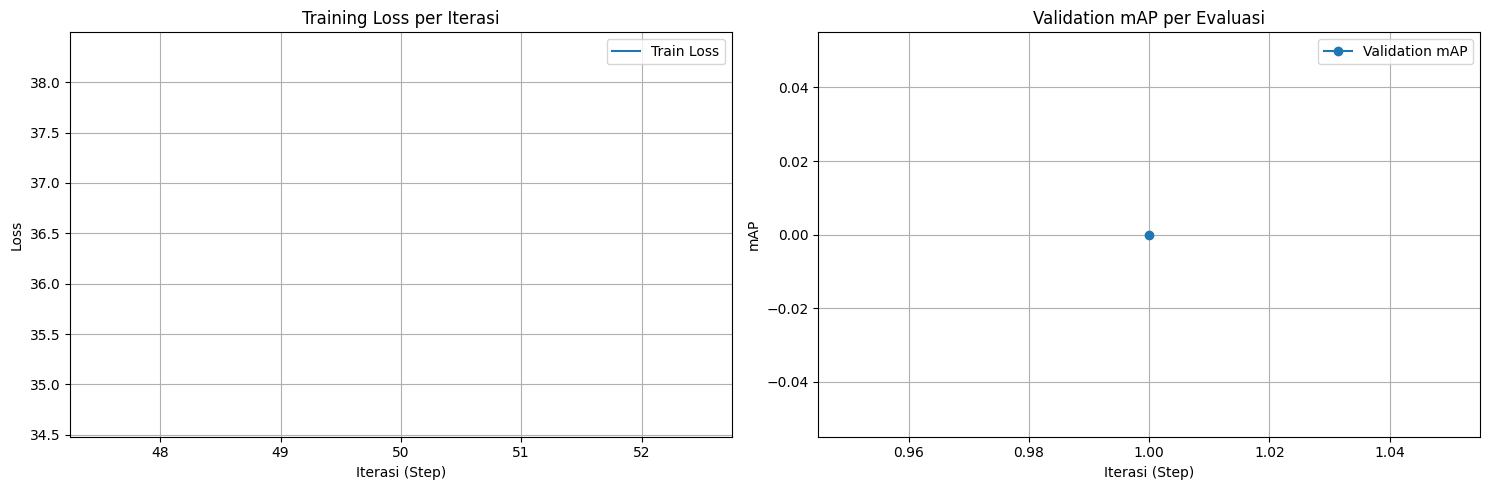


===== Performa Terbaik =====
Iterasi (Step): 1
mAP: 0.0000
mAP_50: 0.0010
mAP_75: 0.0000


In [7]:
# SEL 5 (FINAL - MENGGUNAKAN PATH YANG BENAR)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

log_file = None
if latest_run_dir:
    vis_data_path = os.path.join(latest_run_dir, 'vis_data')
    if os.path.exists(vis_data_path):
        # Cari file .json di dalam vis_data (biasanya ada 2: scalars.json dan [timestamp].json)
        # Kita ingin yang [timestamp].json karena berisi semua data.
        for file in os.listdir(vis_data_path):
            if file.endswith('.json') and 'scalars' not in file:
                log_file = os.path.join(vis_data_path, file)
                break

if not log_file:
    print("File log .json tidak ditemukan. Pastikan Sel 4 telah berjalan dan Sel 4.5 menemukan direktori run yang benar.")
else:
    print(f"Membaca log dari: {log_file}")
    
    # Lanjutkan dengan sisa kode seperti sebelumnya...
    log_data = []
    with open(log_file, 'r') as f:
        for line in f:
            try:
                log_data.append(pd.json_normalize(json.loads(line)))
            except json.JSONDecodeError:
                continue
    
    if log_data:
        log_df = pd.concat(log_data, ignore_index=True)
        train_log = log_df[log_df['loss'].notna()]
        val_log = log_df[log_df['coco/bbox_mAP'].notna()]

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        if not train_log.empty:
            plt.plot(train_log['step'], train_log['loss'], label='Train Loss')
        plt.title('Training Loss per Iterasi')
        plt.xlabel('Iterasi (Step)')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        if not val_log.empty:
            plt.plot(val_log['step'], val_log['coco/bbox_mAP'], label='Validation mAP', marker='o')
        plt.title('Validation mAP per Evaluasi')
        plt.xlabel('Iterasi (Step)')
        plt.ylabel('mAP')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        if not val_log.empty:
            best_map_row = val_log.loc[val_log['coco/bbox_mAP'].idxmax()]
            print("\n===== Performa Terbaik =====")
            print(f"Iterasi (Step): {int(best_map_row['step'])}")
            print(f"mAP: {best_map_row['coco/bbox_mAP']:.4f}")
            print(f"mAP_50: {best_map_row['coco/bbox_mAP_50']:.4f}")
            print(f"mAP_75: {best_map_row['coco/bbox_mAP_75']:.4f}")
        else:
            print("\nTidak ada data validasi yang tercatat di log.")
    else:
        print("Tidak ada data valid yang bisa dibaca dari file log.")

c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmcv\cnn\bricks\hsigmoid.py:35: UserWarning: In MMCV v1.4.4, we modified the default value of args to align with PyTorch official. Previous Implementation: Hsigmoid(x) = min(max((x + 1) / 2, 0), 1). Current Implementation: Hsigmoid(x) = min(max((x + 3) / 6, 0), 1).
  warnings.warn(


Menggunakan model dari: outputs/BreadDetector_SSD_MobileNetV3\best_coco_bbox_mAP_epoch_1.pth
Membangun model dari konfigurasi...
Memuat checkpoint dengan `weights_only=False`...
Model berhasil dibuat dan bobot dimuat.
Membuat prediksi untuk confusion matrix...


100%|██████████| 567/567 [00:28<00:00, 20.13it/s]


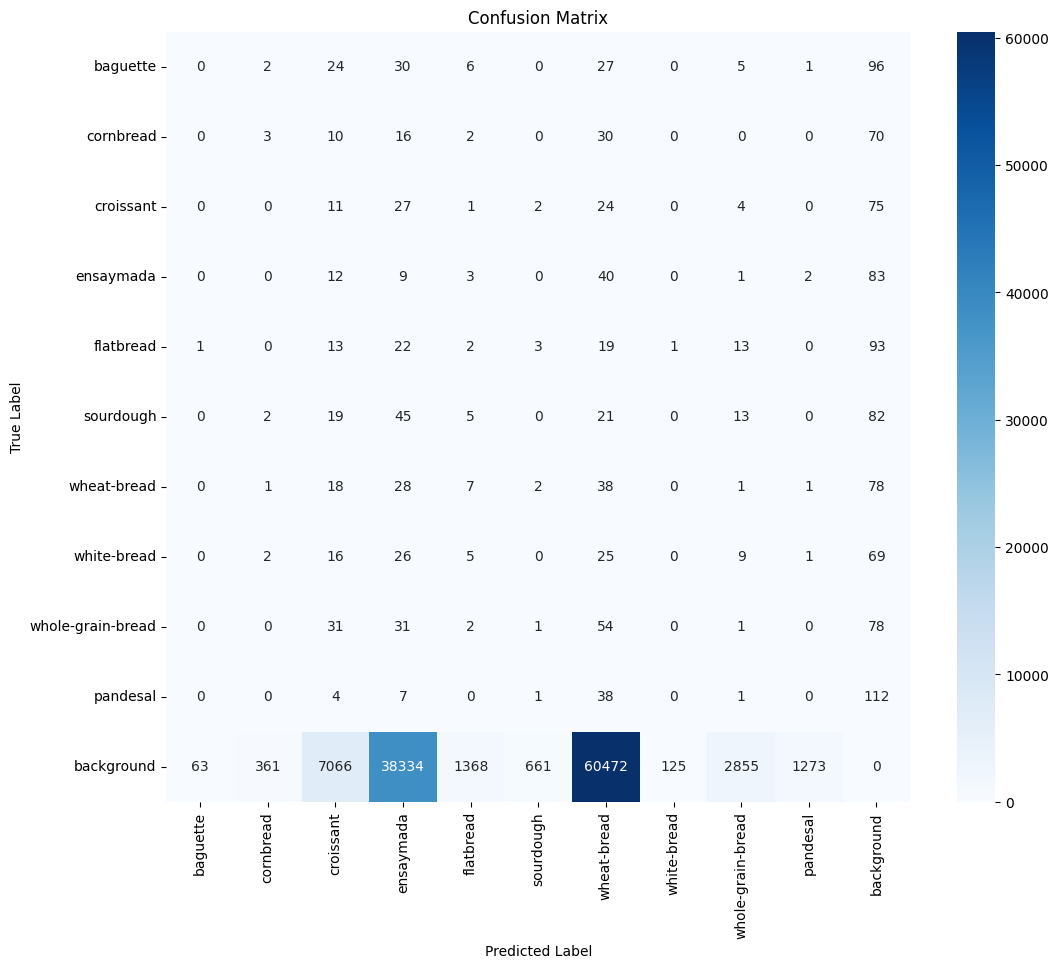

In [8]:
# SEL 6 (FINAL - INFERENSI MANUAL UNTUK MENGHINDARI SEMUA MASALAH)

import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json

# Impor yang diperlukan untuk membangun model dan pipeline secara manual
from mmdet.registry import MODELS as MMDET_MODELS
from mmengine.dataset import Compose
from mmdet.structures import DetDataSample
from mmengine.structures import InstanceData

# --- Langkah 1: Cari path ke checkpoint terbaik (kode ini sudah benar) ---
best_checkpoint_path = None
if os.path.exists(WORK_DIR):
    for file in os.listdir(WORK_DIR):
        if file.startswith('best_coco_bbox_mAP') and file.endswith('.pth'):
            best_checkpoint_path = os.path.join(WORK_DIR, file)
            break
    if not best_checkpoint_path:
        epochs = []
        epoch_files = {}
        for f in os.listdir(WORK_DIR):
            if f.startswith('epoch_') and f.endswith('.pth'):
                try:
                    epoch_num = int(f.split('_')[1].split('.')[0])
                    epochs.append(epoch_num)
                    epoch_files[epoch_num] = f
                except (ValueError, IndexError):
                    continue
        if epochs:
            latest_epoch = max(epochs)
            best_checkpoint_path = os.path.join(WORK_DIR, epoch_files[latest_epoch])

if not best_checkpoint_path:
    raise FileNotFoundError(f"Tidak ada file checkpoint (.pth) yang ditemukan di: {WORK_DIR}")

print(f"Menggunakan model dari: {best_checkpoint_path}")


# --- Langkah 2: Bangun model dan muat bobot secara manual ---
print("Membangun model dari konfigurasi...")
model = MMDET_MODELS.build(cfg.model)

print("Memuat checkpoint dengan `weights_only=False`...")
checkpoint = torch.load(best_checkpoint_path, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['state_dict'], strict=False)

# Pindahkan model ke GPU dan set ke mode evaluasi
model.to('cuda')
model.eval()
print("Model berhasil dibuat dan bobot dimuat.")


# --- Langkah 3: Bangun pipeline pemrosesan data untuk inferensi ---
# Hapus langkah 'LoadAnnotations' karena tidak diperlukan untuk inferensi
test_pipeline_cfg = [p for p in cfg.test_pipeline if p['type'] != 'LoadAnnotations']
pipeline = Compose(test_pipeline_cfg)


# --- Langkah 4: Loop melalui data validasi dan lakukan inferensi manual ---
with open(filtered_valid_ann, 'r') as f:
    val_data = json.load(f)

y_true = []
y_pred = []
iou_threshold = 0.5

print("Membuat prediksi untuk confusion matrix...")
with torch.no_grad():  # Pastikan tidak ada gradien yang dihitung
    for img_info in tqdm(val_data['images']):
        img_path = os.path.join(DATASET_ROOT, 'valid', img_info['file_name'])
        
        # Proses gambar melalui pipeline
        data_info = {'img_path': img_path, 'img_id': 0}
        processed_data = pipeline(data_info)
        
        # Format data untuk model
        inputs = processed_data['inputs'].unsqueeze(0).to('cuda')
        
        # 👇 Tambahkan baris ini untuk konversi tipe tensor
        if inputs.dtype == torch.uint8:  
            inputs = inputs.float() / 255.0  # 👈 DITAMBAHKAN
        
        data_sample = processed_data['data_samples']
        data_sample.set_metainfo({'img_path': img_path})  # Tambahkan info path
        batch_data_samples = [data_sample]
        
        # Jalankan inferensi
        results_list = model.predict(inputs, batch_data_samples)
        
        # Ekstrak hasil prediksi
        pred_instances = results_list[0].pred_instances
        pred_labels = pred_instances.labels.cpu().numpy()
        pred_boxes = pred_instances.bboxes.cpu().numpy()

        # --- Perhitungan confusion matrix (sudah benar) ---
        gt_anns = [ann for ann in val_data['annotations'] if ann['image_id'] == img_info['id']]
        gt_boxes = np.array([ann['bbox'] for ann in gt_anns])
        gt_labels = np.array([ann['category_id'] for ann in gt_anns])
        
        if gt_boxes.shape[0] > 0:
            gt_boxes[:, 2] += gt_boxes[:, 0]
            gt_boxes[:, 3] += gt_boxes[:, 1]
        
        if len(gt_boxes) == 0:
            for label in pred_labels:
                y_true.append(NUM_CLASSES)
                y_pred.append(label)
            continue
        
        if len(pred_boxes) == 0:
            for label in gt_labels:
                y_true.append(label)
                y_pred.append(NUM_CLASSES)
            continue

        used_preds = set()
        for i, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
            best_iou = 0
            best_pred_idx = -1
            for j, pred_box in enumerate(pred_boxes):
                if j in used_preds:
                    continue
                xA = max(gt_box[0], pred_box[0])
                yA = max(gt_box[1], pred_box[1])
                xB = min(gt_box[2], pred_box[2])
                yB = min(gt_box[3], pred_box[3])
                interArea = max(0, xB - xA) * max(0, yB - yA)
                boxAArea = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
                boxBArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
                iou = interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0
                if iou > best_iou:
                    best_iou = iou
                    best_pred_idx = j
            if best_iou > iou_threshold:
                y_true.append(gt_label)
                y_pred.append(pred_labels[best_pred_idx])
                used_preds.add(best_pred_idx)
            else:
                y_true.append(gt_label)
                y_pred.append(NUM_CLASSES)
        for j, pred_label in enumerate(pred_labels):
            if j not in used_preds:
                y_true.append(NUM_CLASSES)
                y_pred.append(pred_label)

# Buat confusion matrix (kode ini sudah benar)
cm_labels = list(range(NUM_CLASSES + 1))
cm = confusion_matrix(y_true, y_pred, labels=cm_labels)

plt.figure(figsize=(12, 10))
cm_display_labels = CLASSES_TO_USE + ['background']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_display_labels, yticklabels=cm_display_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmengine\visualization\visualizer.py:760: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmengine\visualization\visualizer.py:831: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


Menampilkan hasil deteksi untuk 5 gambar acak...


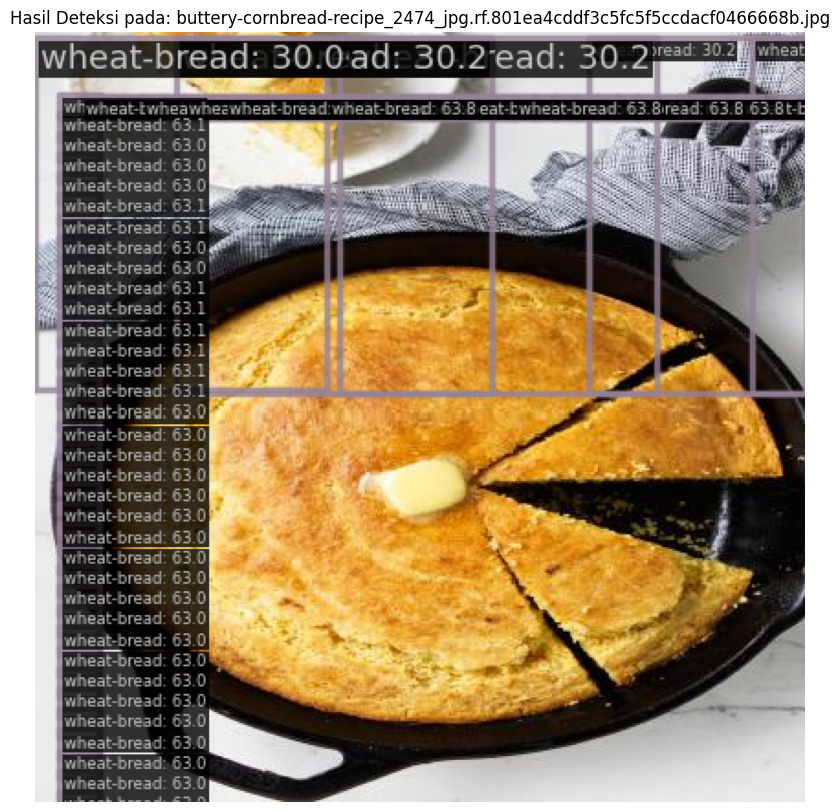

c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmengine\visualization\visualizer.py:508: UserWarning: Warning: The text is out of bounds, the drawn text may not be in the image
  warnings.warn(


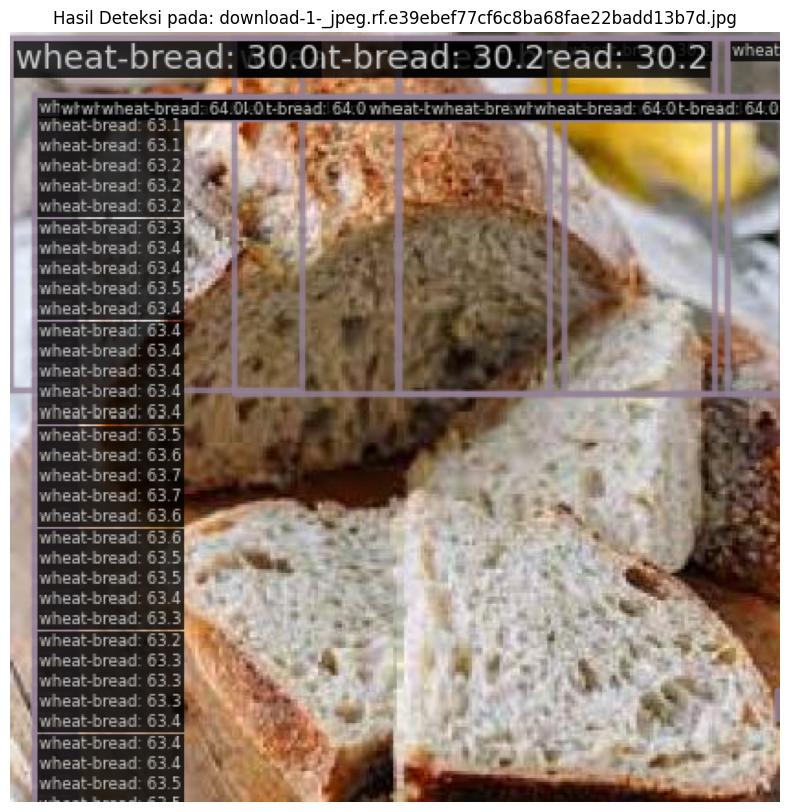

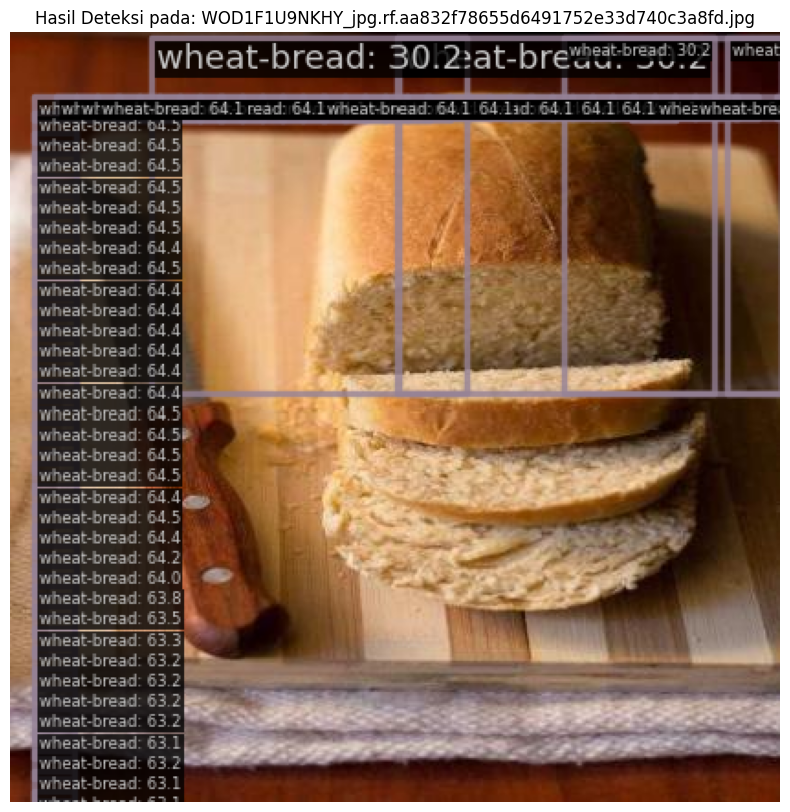

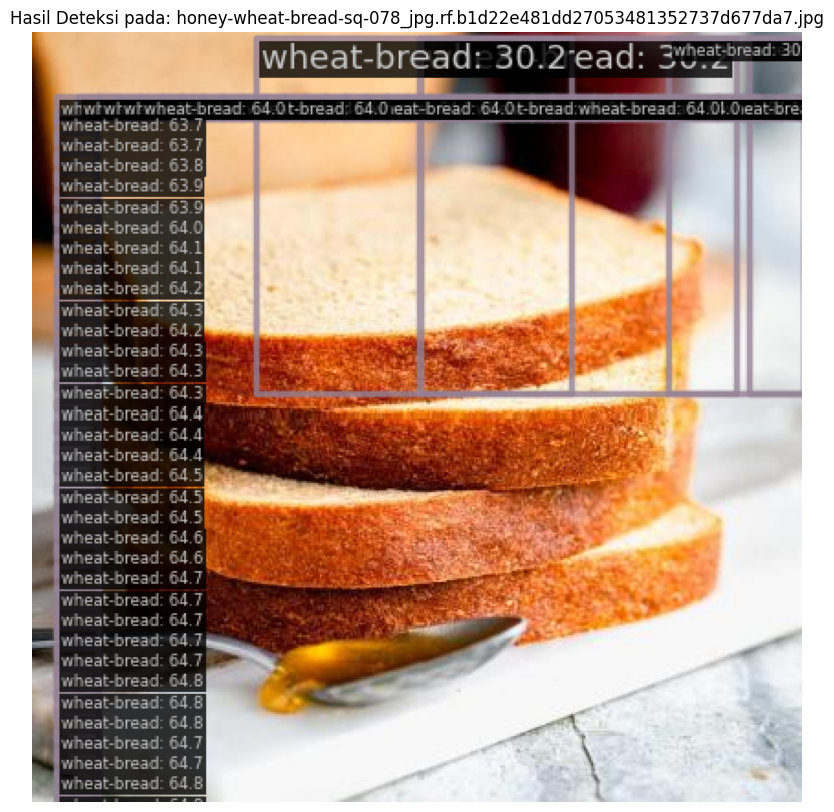

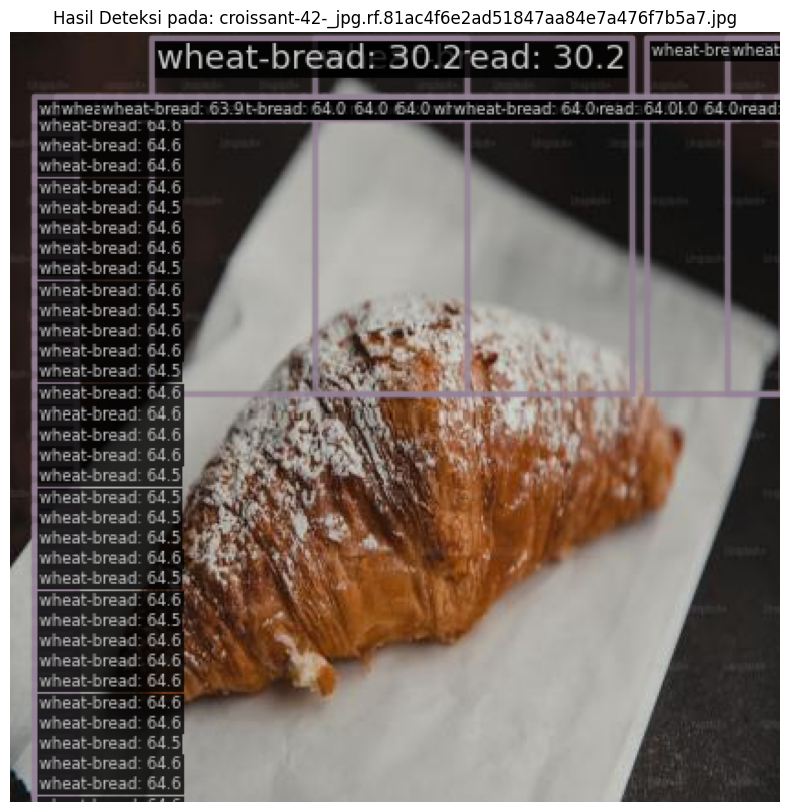

In [9]:
# SEL 7 (FINAL - VISUALISASI MANUAL MENGGUNAKAN MODEL DARI SEL 6)

import cv2
import random
import matplotlib.pyplot as plt
from mmdet.visualization import DetLocalVisualizer
import mmcv

# --- Pastikan Sel 6 sudah dijalankan terlebih dahulu untuk mendefinisikan 'model' dan 'pipeline' ---
if 'model' not in locals() or 'pipeline' not in locals():
    raise RuntimeError("Harap jalankan Sel 6 terlebih dahulu untuk membangun model dan pipeline.")

# --- 1. Inisialisasi Visualizer ---
# Visualizer adalah alat modern di MMDetection untuk menggambar bbox
visualizer = DetLocalVisualizer(
    vis_backends=[dict(type='LocalVisBackend')],
    name='visualizer'
)
# Beri tahu visualizer tentang kelas-kelas kita
visualizer.dataset_meta = cfg.val_dataloader.dataset.metainfo


# --- 2. Ambil beberapa gambar acak dari set validasi ---
with open(filtered_valid_ann, 'r') as f:
    val_data = json.load(f)
val_images = val_data['images']
# Ambil maksimal 5 sampel, atau lebih sedikit jika dataset validasi kecil
num_samples = min(5, len(val_images))
random_samples = random.sample(val_images, k=num_samples)


# --- 3. Lakukan inferensi dan visualisasi untuk setiap gambar sampel ---
print(f"Menampilkan hasil deteksi untuk {num_samples} gambar acak...")
with torch.no_grad():
    for img_info in random_samples:
        img_path = os.path.join(DATASET_ROOT, 'valid', img_info['file_name'])
        
        # Baca gambar mentah (dalam format BGR)
        original_image = mmcv.imread(img_path)

        # Proses gambar melalui pipeline (sama seperti di Sel 6)
        data_info = {'img_path': img_path, 'img_id': 0}
        processed_data = pipeline(data_info)
        inputs = processed_data['inputs'].unsqueeze(0).to('cuda').float() / 255.0
        batch_data_samples = [processed_data['data_samples']]
        
        # Jalankan inferensi
        results_list = model.predict(inputs, batch_data_samples)
        
        # Dapatkan hasil deteksi dari data sample
        result_data_sample = results_list[0]
        
        # Gunakan visualizer untuk menggambar bbox pada gambar
        visualizer.add_datasample(
            name='prediction',
            image=original_image,
            data_sample=result_data_sample,
            draw_gt=False, # Kita hanya ingin melihat prediksi
            show=False # Jangan tampilkan jendela baru
        )
        
        # Ambil gambar yang sudah digambari dari visualizer
        visualized_image = visualizer.get_image()
        
        # Tampilkan menggunakan matplotlib (konversi BGR ke RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(visualized_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Hasil Deteksi pada: {img_info['file_name']}")
        plt.axis('off')
        plt.show()